In [56]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten, Dropout, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.resnet50 import preprocess_input 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

In [27]:

labels = pd.read_csv('./dataset/label.csv')

#get images from file name
def fetch_image(row_id, root = "./dataset/image/"):
    file_name = f"IMAGE_{str.zfill(str(row_id), 4)}.jpg"
    file_path = os.path.join(root, file_name)
    img = Image.open(file_path)
    return np.array(img)

width = fetch_image(1).shape[0]
height = fetch_image(1).shape[1]
depth = fetch_image(1).shape[2]


In [28]:

# create new column for labels: 1 if patient has cancer 0 if not for binary classification

labels.loc[labels.label != "no_tumor", "cancer"] = '1'
labels.loc[labels.label == "no_tumor", "cancer"] = '0'

labels.head()

,file_name,label,cancer
0,IMAGE_0000.jpg,meningioma_tumor,1
1,IMAGE_0001.jpg,no_tumor,0
2,IMAGE_0002.jpg,meningioma_tumor,1
3,IMAGE_0003.jpg,glioma_tumor,1
4,IMAGE_0004.jpg,meningioma_tumor,1


In [29]:

batch_size = 32

epochs = 15

# Image Generators (Training and Validation)
datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=90,
                                  horizontal_flip= True,
                                  vertical_flip=True,
                                  shear_range= 0.2,
                                  zoom_range= 0.2,
                                  preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                  validation_split= 0.2) 


data_directory = "./dataset/image"

train_data_gen = datagen.flow_from_dataframe(labels,
                                                  directory = data_directory, 
                                                  x_col = 'file_name',
                                                  y_col = 'cancer',
                                                  subset="training",
                                                  target_size= (width, height),
                                                  batch_size=batch_size,
                                                  class_mode="binary")

val_data_gen = datagen.flow_from_dataframe(labels,
                                              directory = data_directory,
                                              x_col = 'file_name',
                                              y_col = 'cancer',
                                              subset="validation",
                                              target_size= (width, height),
                                              batch_size=batch_size, 
                                              class_mode="binary")

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [30]:
input_tensor = tf.keras.Input(shape=(width, height, depth))

resnet_model = ResNet50(include_top= False, weights = 'imagenet', input_tensor=input_tensor)

for layer in resnet_model.layers:
    layer.trainable = False

In [43]:
def create_features(row_id):
    img = fetch_image(row_id)

    x = np.expand_dims(img, axis = 0)

    x = preprocess_input(x)

    features = resnet_model.predict(x).flatten()
    
    features = features[np.nonzero(features)][:20000]
    
    return features

create_features(3).shape

(20000,)

In [45]:
def combine_features(labels):
    features = np.empty((0, create_features(1).shape[0]), int)
    
    for img_id in labels.index:
        image_features = create_features(img_id)
        features = np.vstack([features,image_features])
        
    return features

feature_matrix = combine_features(labels)

In [48]:

ss = StandardScaler()

scaled_features = ss.fit_transform(feature_matrix)

pca = PCA(n_components=50)

pca_features = pca.fit_transform(scaled_features)


print(pca_features.shape)

(3000, 50)


In [50]:
print(feature_matrix[:20])

np.savetxt('res.csv', feature_matrix, delimiter=',')   # X is an array

[[ 3.13273335  5.73705912  0.53060162 ...  1.01650393  1.95821071
   2.37403774]
 [ 0.03524446  5.34070253  1.80082989 ...  2.89295721  1.08830202
   0.70430505]
 [ 2.74504709  0.89862335  1.55770099 ...  1.00874937  1.86602604
   2.29766154]
 ...
 [ 1.10022998  6.30121279  0.31704974 ...  6.76010895  7.74745464
   8.05720901]
 [ 2.7178154   4.938941    2.7046392  ...  0.0950923   3.43935919
   0.89874864]
 [ 0.78413987  5.47834969  1.17994726 ... 11.59351063  2.38517237
   2.8149786 ]]


In [52]:

X = pd.DataFrame(pca_features)
X.to_csv('pca_res.csv', index = False)
y = pd.Series(labels.label.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

glioma_tumor        614
meningioma_tumor    591
pituitary_tumor     576
no_tumor            319
dtype: int64

In [53]:
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
# define support vector classifier
svm = SVC(probability=True)

model = GridSearchCV(svm, param_grid)
# fit model
model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [54]:
y_pred = model.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.5388888888888889


Confusion matrix, without normalization
[[145  46   7  48]
 [ 65 132  19  48]
 [ 30  11  72  22]
 [ 79  28  12 136]]
Normalized confusion matrix
[[0.58943089 0.18699187 0.02845528 0.19512195]
 [0.24621212 0.5        0.0719697  0.18181818]
 [0.22222222 0.08148148 0.53333333 0.16296296]
 [0.30980392 0.10980392 0.04705882 0.53333333]]


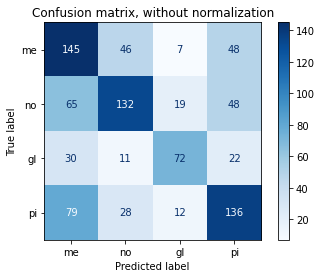

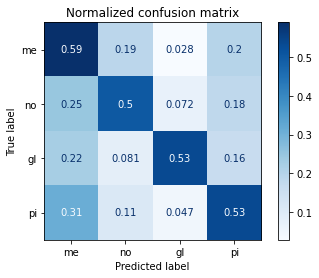

In [57]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=labels.label.str[:2].unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

In [58]:
print(classification_report(y_test, y_pred, target_names=labels.label.unique()))

                  precision    recall  f1-score   support

meningioma_tumor       0.45      0.59      0.51       246
        no_tumor       0.61      0.50      0.55       264
    glioma_tumor       0.65      0.53      0.59       135
 pituitary_tumor       0.54      0.53      0.53       255

        accuracy                           0.54       900
       macro avg       0.56      0.54      0.55       900
    weighted avg       0.55      0.54      0.54       900



In [59]:
model.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [60]:
cv = KFold(n_splits=10, shuffle=False)
r_scores = []

for train_idx, test_idx in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    r_scores.append(model.score(X_test, y_test))

In [ ]:
print(r_scores)